How does our Y1 TFR compare with that of Cosmicflows-4?

Also, how do our rotational velocities compare with ALFALFA's (which is what Cosmicflows-4 used)?

In [82]:
import numpy as np

from astropy.io import fits
from astropy.table import Table, unique, join
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.constants as const

import pickle

from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [2]:
c = const.c.to('km/s')

q0 = 0.2

# Data

## Iron

In [83]:
# hdul = fits.open('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y1/DESI-DR1_TF_pv_cat_v4.fits.fits')
hdul = fits.open('SGA_iron_jointTFR-varyV0-perpdwarf-fitH0_zCMB0p1_moduli.fits')
hdr = hdul[0].header
SGA = Table(hdul[1].data)
hdul.close()

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,Z_DESI_CMB,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,MU_ZCMB,R_ABSMAG_SB26,MU_ZCMB_ERR,R_ABSMAG_SB26_ERR,DWARF,R_ABSMAG_SB26_TF,R_ABSMAG_SB26_TF_ERR,R_ABSMAG_SB26_TF_ERR_STAT,R_ABSMAG_SB26_TF_ERR_SYS,MU_TF,MU_TF_ERR,LOGDIST,LOGDIST_ERR
int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.03717674

## SGA w/ ALFALFA catalog indices

In [12]:
# SGA_ALFALFA = Table.read('/pscratch/sd/k/kadglass/data/SGA-2020_ALFALFA.fits')
SGA_ALFALFA = Table.read('/Users/kdouglass/Documents/Research/data/SGA/SGA-2020_ALFALFA.fits')
SGA_ALFALFA = SGA_ALFALFA['SGA_ID', 'ALFALFA_index']

SGA_ALFALFA['ALFALFA_index'].name = 'ALFALFA_AGCNr'

SGA_ALFALFA[:5]

SGA_ID,ALFALFA_AGCNr
int64,int64
2,-1
3,-1
4,-1
7,-1
18,-1


### Add ALFALFA catalog indices to main data table

In [84]:
SGA = join(SGA, SGA_ALFALFA)
SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,Z_DESI_CMB,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,MU_ZCMB,R_ABSMAG_SB26,MU_ZCMB_ERR,R_ABSMAG_SB26_ERR,DWARF,R_ABSMAG_SB26_TF,R_ABSMAG_SB26_TF_ERR,R_ABSMAG_SB26_TF_ERR_STAT,R_ABSMAG_SB26_TF_ERR_SYS,MU_TF,MU_TF_ERR,LOGDIST,LOGDIST_ERR,ALFALFA_AGCNr
int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,int64
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0

## ALFALFA

Read in our version of the SGA that includes the index value of the galaxy in the ALFALFA data file.  (This file was made with the `ALFALFA_radec_match.py` script, currently living in my (Kelly's) data folder on my local machine.)

In [15]:
# ALFALFA = Table.read('/pscratch/sd/k/kadglass/data/a100.code12.table2.190808.txt', 
ALFALFA = Table.read('/Users/kdouglass/Documents/Research/data/ALFALFA/a100.code12.table2.190808.txt',
                     format='ascii.csv', 
                     include_names=['AGCNr', 'W50', 'sigW', 'W20'])

ALFALFA[:5]

AGCNr,W50,sigW,W20
int64,int64,int64,int64
105367,274,39,281
333313,313,20,333
331060,160,4,184
331061,260,45,268
104570,245,6,250


In [16]:
ALFALFA_dict = {}

for i in range(len(ALFALFA)):
    
    ALFALFA_dict[ALFALFA['AGCNr'][i]] = i

## Add the HI velocities to the main data table

In [85]:
SGA['V_HI'] = np.nan
SGA['VERR_HI'] = np.nan
SGA['V20_HI'] = np.nan

for i in range(len(SGA['SGA_ID'])):
    
    # Set the HI velocity width of this galaxy
    if SGA['ALFALFA_AGCNr'][i] >= 0:
        
        ALFALFA_idx = ALFALFA_dict[SGA['ALFALFA_AGCNr'][i]]
        
        SGA['V_HI'][i] = ALFALFA['W50'][ALFALFA_idx] - 6. # Adjustment from Kourkchi et al. (2020a), Sec. 2.2
        SGA['VERR_HI'][i] = ALFALFA['sigW'][ALFALFA_idx]
        SGA['V20_HI'][i] = ALFALFA['W20'][ALFALFA_idx]

### Filter SGA to keep only those objects with center observations and HI velocities

In [86]:
HI = np.isfinite(SGA['V_HI'])

print('Y1 galaxies with HI velocities and rotational velocities:', np.sum(HI))

Y1 galaxies with HI velocities and rotational velocities: 1069


In [87]:
iron_HI = SGA[HI]

## Visual inspection cut

This removes any observations that are contaminated by foreground stars or other galaxies.

**Note: THIS STILL NEEDS TO BE DONE!** VI was done in the `fuji_zero-point_ALFALFA_KAD.ipynb` notebook.

In [22]:
VI_remove = Table.read('iron_VI.txt', format='ascii.commented_header')
'''
remove_targets = np.zeros(len(good_edge_spirals_axis_dist), dtype=bool)

for targetid in VI_remove['TARGETID']:
    
    remove_targets = remove_targets & (good_edge_spirals_axis_dist['TARGETID'] == targetid)
    
VI_good_edge_spirals_axis_dist = good_edge_spirals_axis_dist[~remove_targets]

print(len(VI_good_edge_spirals_axis_dist), len(np.unique(VI_good_edge_spirals_axis_dist['SGA_ID'])))

# VI_good_edge_spirals_axis_dist = good_edge_spirals_axis_dist
''';

223 106


# Comparison of the two TFRs

## Compute the absolute magnitudes based on the Cosmicflows-4 TFR

### First, we need to correct the HI velocities for the inclination angle.

In [88]:
iron_HI['cosi2'] = (iron_HI['BA']**2 - q0**2)/(1 - q0**2)
iron_HI['cosi2'][iron_HI['cosi2'] < 0] = 0

iron_HI['V_HI_corr'] = iron_HI['V_HI']/np.sin(np.arccos(np.sqrt(iron_HI['cosi2'])))
iron_HI['VERR_HI_corr'] = iron_HI['VERR_HI']/np.sin(np.arccos(np.sqrt(iron_HI['cosi2'])))

iron_HI['V20_HI_corr'] = iron_HI['V20_HI']/np.sin(np.arccos(np.sqrt(iron_HI['cosi2'])))

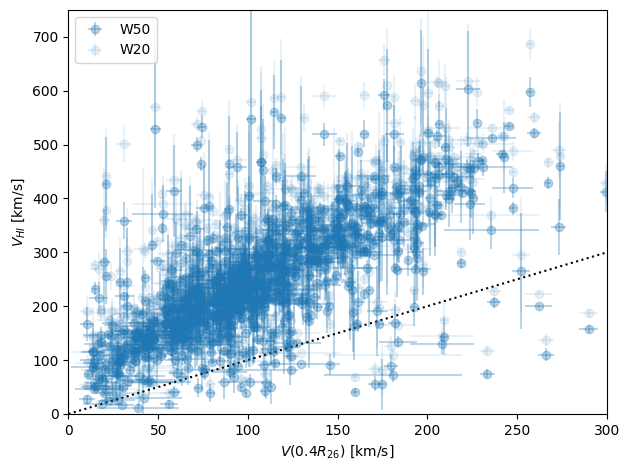

In [89]:
plt.figure(tight_layout=True)

plt.errorbar(iron_HI['V_0p4R26'], iron_HI['V_HI_corr'], 
             xerr=iron_HI['V_0p4R26_ERR'], 
             yerr=iron_HI['VERR_HI_corr'], 
             fmt='o', 
             alpha=0.3, 
             label='W50')
plt.errorbar(iron_HI['V_0p4R26'], iron_HI['V20_HI_corr'], 
             xerr=iron_HI['V_0p4R26_ERR'], 
             yerr=iron_HI['VERR_HI_corr'], 
             fmt='o', 
             alpha=0.1,
             c='tab:blue', 
             label='W20')

plt.plot([0, 800], [0, 800], 'k:')

# plt.hlines(90, 0, 300, colors='r', linestyles='dashed', label='W20 = 90 km/s')

plt.xlim([0, 300])
plt.ylim([0, 750])

plt.legend()

plt.xlabel('$V(0.4R_{26})$ [km/s]')
plt.ylabel('$V_{HI}$ [km/s]');

### Now, we use the Tully-Fisher relation calibrated by Cosmicflows-4 (Kourkchi+ 2020) to calculate the absolute magnitudes of these galaxies

Cosmicflows-4 TF calibration:
\begin{equation}
  \overline{M_\lambda} = \text{Slope} \left( \log W^i_{mx} - 2.5 \right) + \overline{\text{ZP}}
\end{equation}
where
\begin{equation}
  \overline{\text{ZP}} = \text{ZP} + C_{zp}
\end{equation}
is a correction to the zero-point to account for slightly different distance moduli found with different passbands for the same clusters.

For the $r$-band, the parameter values are
 * slope $= -7.96\pm 0.13$
 * ZP $= -20.57\pm 0.10$
 * $C_{zp} = -0.08\pm 0.13$
 * $\sigma = 0.49$ (cluster calibrators)

In [98]:
CF4_slope = -7.96
CF4_slope_err = 0.13

CF4_ZP = -20.57
CF4_ZP_err = 0.10

CF4_Czp = -0.08
CF4_Czp_err = 0.13

CF4_sig = 0.49

iron_HI['R_ABSMAG_SB26_CF4'] = CF4_slope*(np.log10(iron_HI['V_HI_corr'] - 6) - 2.5) + CF4_ZP + CF4_Czp

In [91]:
N_samples = 100000

rng = np.random.default_rng()

m_random = rng.normal(CF4_slope, CF4_slope_err, size=N_samples)
b_random = rng.normal(CF4_ZP, CF4_ZP_err, size=N_samples)
bp_random = rng.normal(CF4_Czp, CF4_Czp_err, size=N_samples)

iron_HI['R_ABSMAG_SB26_CF4_err'] = np.nan
iron_HI['R_ABSMAG_SB26_CF4_err_stat'] = np.nan

for i in range(len(iron_HI)):
    
    v_random = rng.normal(iron_HI['V_HI_corr'][i], 
                          iron_HI['VERR_HI_corr'][i], 
                          size=N_samples)
    
    ############################################################################
    # Statistical uncertainty
    #---------------------------------------------------------------------------
    Ms_stat = CF4_slope*(np.log10(v_random - 6) - 2.5) + CF4_ZP + CF4_Czp
    
    iron_HI['R_ABSMAG_SB26_CF4_err_stat'][i] = np.nanstd(Ms_stat)
    ############################################################################
    
    
    ############################################################################
    # Total uncertainty
    #---------------------------------------------------------------------------
    Ms = m_random*(np.log10(v_random - 6) - 2.5) + b_random + bp_random
    
    iron_HI['R_ABSMAG_SB26_CF4_err'][i] = np.nanstd(Ms)
    ############################################################################
    
    
################################################################################
# Systematic uncertainty
#-------------------------------------------------------------------------------
iron_HI['R_ABSMAG_SB26_CF4_err_sys'] = np.sqrt(iron_HI['R_ABSMAG_SB26_CF4_err']**2 - iron_HI['R_ABSMAG_SB26_CF4_err_stat']**2)
################################################################################

/var/folders/mg/fxh1s24d0n3_r0c39d3gs0g00000gq/T/ipykernel_37117/414783144.py:21: RuntimeWarning: invalid value encountered in log10
  Ms_stat = CF4_slope*(np.log10(v_random - 6) - 2.5) + CF4_ZP + CF4_Czp
/var/folders/mg/fxh1s24d0n3_r0c39d3gs0g00000gq/T/ipykernel_37117/414783144.py:30: RuntimeWarning: invalid value encountered in log10
  Ms = m_random*(np.log10(v_random - 6) - 2.5) + b_random + bp_random


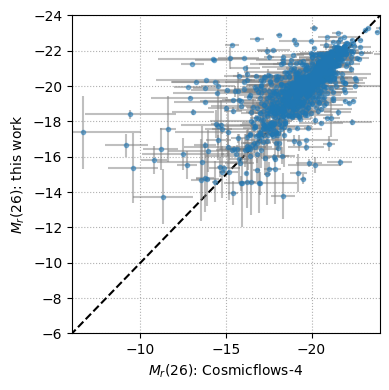

In [92]:
plt.figure(figsize=(4,4), tight_layout=True)

plt.grid(ls=':')

plt.plot([-5, -28], [-5, -28], 'k--')

plt.errorbar(iron_HI['R_ABSMAG_SB26_CF4'], iron_HI['R_ABSMAG_SB26_TF'], 
             xerr=iron_HI['R_ABSMAG_SB26_CF4_err_stat'], 
             yerr=iron_HI['R_ABSMAG_SB26_TF_ERR_STAT'], 
             fmt='.', 
             alpha=0.5, 
             ecolor='gray'
            )

plt.xlim([-6, -24])
plt.ylim([-6, -24])

plt.xlabel('$M_r(26)$: Cosmicflows-4')
plt.ylabel('$M_r(26)$: this work');

In [93]:
# Restrict the sample to the range allowed by the Cosmicflows-4 calibration

StoN = iron_HI['V_HI']/iron_HI['VERR_HI']

CF4_boolean = (StoN > 10) & ((iron_HI['V_HI_corr'] - 6) > 64)

print(sum(CF4_boolean))

677


In [94]:
# Mark dwarf galaxies differently
dwarf_boolean = iron_HI['DWARF']

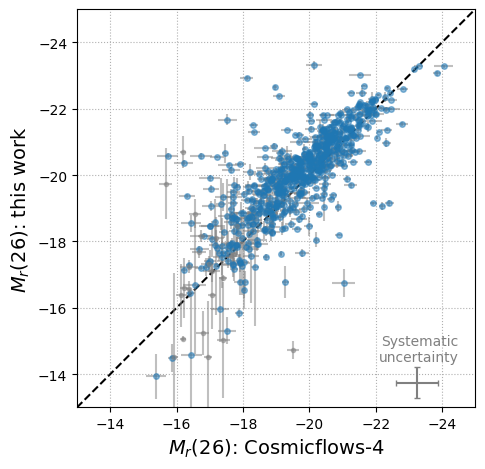

In [99]:
H0 = 76.0 # From Kourkchi et al. (2020a)
h = H0/100

#plt.figure(figsize=(4,4), tight_layout=True)
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.plot([-5, -28], [-5, -28], '--', color='k')#'lightgray')
# plt.plot([-5, -28], np.array([-5, -28]) - 5*np.log(h), 'k--') # with H0 from Cosmicflows 4

plt.errorbar(iron_HI['R_ABSMAG_SB26_CF4'][CF4_boolean & ~dwarf_boolean], iron_HI['R_ABSMAG_SB26_TF'][CF4_boolean & ~dwarf_boolean], 
             xerr=iron_HI['R_ABSMAG_SB26_CF4_err_stat'][CF4_boolean & ~dwarf_boolean], 
             yerr=iron_HI['R_ABSMAG_SB26_TF_ERR_STAT'][CF4_boolean & ~dwarf_boolean], 
             fmt='o', 
             markersize=4,
             alpha=0.5, 
             ecolor='gray')
plt.errorbar(iron_HI['R_ABSMAG_SB26_CF4'][CF4_boolean & dwarf_boolean], iron_HI['R_ABSMAG_SB26_TF'][CF4_boolean & dwarf_boolean], 
             xerr=iron_HI['R_ABSMAG_SB26_CF4_err_stat'][CF4_boolean & dwarf_boolean], 
             yerr=iron_HI['R_ABSMAG_SB26_TF_ERR_STAT'][CF4_boolean & dwarf_boolean], 
             fmt='.',
             color='gray',
             alpha=0.5, 
             ecolor='gray')

# Systematic error bar example
plt.errorbar([-23.25], [-13.75], 
             xerr=np.sqrt(np.nanmean(iron_HI['R_ABSMAG_SB26_CF4_err_sys'][CF4_boolean]) + CF4_sig**2),
             yerr=np.sqrt(np.nanmean(iron_HI['R_ABSMAG_SB26_TF_ERR_SYS'][CF4_boolean])**2 + hdr['SIG']**2), 
             # fmt='x', 
             # color='lightgray',
             ecolor='gray', 
             capsize=2)
plt.annotate('Systematic\nuncertainty', 
             (-24.5, -14.75), 
             #rotation='vertical', 
             va='center',
             ha='right',
             c='gray')

plt.gca().set_aspect('equal')

plt.xlim([-13, -25])
plt.ylim([-13, -25])

plt.xlabel('$M_r(26)$: Cosmicflows-4', fontsize=14)
plt.ylabel('$M_r(26)$: this work', fontsize=14);

# plt.savefig('../../Figures/Y1/iron_CF4comp_20250131.png', 
plt.savefig('../../../figures/Y1_papers/iron_CF4comp_20250131.png',
            dpi=150, 
            facecolor='none');

In [53]:
iron_HI[['SGA_ID', 'PGC', 'RA', 'DEC', 'MORPHTYPE', 'V_0p4R26']][dwarf_boolean & CF4_boolean].show_in_notebook()

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


idx,SGA_ID,PGC,RA,DEC,MORPHTYPE,V_0p4R26
0,32759,4017151,131.83181036938652,5.897870505481371,--,17.808517266251986
1,129392,4568096,240.4515836930522,6.838493459844498,I,26.928172956973604
2,205902,90541,20.523076541588885,0.08527595646866079,Sd,57.56479889933931
3,241115,32833,163.9126273612993,2.3951129540435057,I,16.74914790519471
4,291411,27228,143.68691676601995,6.425590837493632,I,65.78944847489693
5,292539,8302,32.59403070183234,1.2010653577290185,IAB,37.87279802095039
6,307356,1263785,171.2726468004553,4.120955556102592,I,32.71046901955528
7,338966,1224591,20.046529354093163,2.3649967089293567,--,14.859911969342022
8,373692,1200167,148.68745011539445,1.6094199956316768,I,36.92258819338759
9,445908,1219195,168.5226877023963,2.1991825607550273,I,26.910794205754108
